<a href="https://colab.research.google.com/github/Sarvesh1814/Image_Segmentation/blob/main/Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Drive and Kaggle API

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!mkdir -p ~/.kaggle
!cp /content/gdrive/MyDrive/DL_DATA/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Downloading Data

In [3]:
!kaggle datasets download -d quadeer15sh/augmented-forest-segmentation


augmented-forest-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip augmented-forest-segmentation.zip


Archive:  augmented-forest-segmentation.zip
replace Forest Segmented/Forest Segmented/images/10452_sat_08.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Processing

In [5]:
import pandas as pd 
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

In [6]:
data = pd.read_csv("/content/Forest Segmented/Forest Segmented/meta_data.csv")
data.head()

,image,mask
0,10452_sat_08.jpg,10452_mask_08.jpg
1,10452_sat_18.jpg,10452_mask_18.jpg
2,111335_sat_00.jpg,111335_mask_00.jpg
3,111335_sat_01.jpg,111335_mask_01.jpg
4,111335_sat_02.jpg,111335_mask_02.jpg


In [7]:
data['image'] = "/content/Forest Segmented/Forest Segmented/images/" + data["image"]
data['mask'] = "/content/Forest Segmented/Forest Segmented/masks/" + data["mask"]

In [9]:
images = []
masks = []

for i in range(len(data)):
    img = cv2.imread(data["image"].iloc[i])
    mask = cv2.imread(data["mask"].iloc[i])
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    mask = cv2.resize(mask, (128, 128))
    mask = mask/255.0
    mask = np.expand_dims(mask[:,:,0], axis=-1)
    images.append(img)
    masks.append(mask)

In [10]:
X_train = np.array(images)
y_train = np.array(masks)


In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# Model Training

In [12]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

In [13]:
input_size=(128, 128, 3)
inputs = Input(input_size)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(256, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
merge6 = concatenate([drop4, up6], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = Conv2D(128, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
merge7 = concatenate([conv3, up7], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = Conv2D(64, (2, 2), activation='relu', padding='same')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(64, (3,3), activation='relu', padding='same')(merge8)
conv8 = Conv2D(64, (3,3), activation='relu', padding='same')(conv8)

up9 = Conv2D(32, (2,2), activation='relu', padding='same')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(32, (3,3), activation='relu', padding='same')(merge9)
conv9 = Conv2D(32, (3,3), activation='relu', padding='same')(conv9)
conv9 = Conv2D(2, (3,3), activation='relu', padding='same')(conv9)
conv10 = Conv2D(1, (1,1), activation='sigmoid')(conv9)


In [14]:
model = Model(inputs = inputs, outputs = conv10)
model.compile(optimizer = "rmsprop", loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [15]:
model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
128/128 [==============================] - 64s 318ms/step - loss: 0.6867 - accuracy: 0.5992 - val_loss: 0.6817 - val_accuracy: 0.6025
Epoch 2/30
128/128 [==============================] - 32s 247ms/step - loss: 0.6784 - accuracy: 0.6006 - val_loss: 0.6747 - val_accuracy: 0.6025
Epoch 3/30
128/128 [==============================] - 31s 246ms/step - loss: 0.6539 - accuracy: 0.6542 - val_loss: 0.6620 - val_accuracy: 0.6447
Epoch 4/30
128/128 [==============================] - 32s 247ms/step - loss: 0.6251 - accuracy: 0.6958 - val_loss: 0.6181 - val_accuracy: 0.7050
Epoch 5/30
128/128 [==============================] - 32s 249ms/step - loss: 0.6071 - accuracy: 0.7098 - val_loss: 0.6108 - val_accuracy: 0.6895
Epoch 6/30
128/128 [==============================] - 32s 247ms/step - loss: 0.5882 - accuracy: 0.7201 - val_loss: 0.5878 - val_accuracy: 0.7205
Epoch 7/30
128/128 [==============================] - 31s 240ms/step - loss: 0.5751 - accuracy: 0.7264 - val_loss: 0.5803 - val_ac

# Model Visualization

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Model Testing

In [17]:
test_path = "/content/Forest Segmented/Forest Segmented/images/111335_sat_03.jpg"
img = cv2.imread(test_path)
img = cv2.resize(img, (128, 128))
img = img / 255.0


In [27]:
pred_mask = model.predict(np.array([img]))
pred_mask = pred_mask.reshape((128, 128))
pred_mask = np.where(pred_mask > 0.5, 1, 0)

1/1 [==============================] - 0s 35ms/step


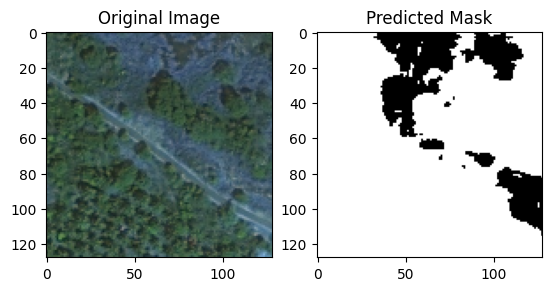

In [28]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[1].imshow(pred_mask, cmap='gray')
axs[1].set_title('Predicted Mask')
plt.show()